In [10]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from utils import PreprocessText
import tensorflow
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.models import Sequential

In [12]:
# Datasets
snoopes=pd.read_csv("data/snoopes.csv")
normal=pd.read_csv("data/metro-water.csv")
mix=pd.read_csv("data/mix.csv")

df = snoopes.append(normal).append(mix)

#check dataset balance
df['label'].value_counts()

False    31862
True     26364
Name: label, dtype: int64

In [14]:
#merge fields
df["text_0"]=df["title"]+df["text"]

In [15]:
#clean data
processed_df=PreprocessText(df)
processed_df.head()

-----Text Preprocessing Started-----
 ----Removing Stopwords---- 
 ----Removing Diatrics---- 
 ----Removing Punctuation---- 
-----Text Preprocessing Finished-----


,title,text,label,Unnamed: 0,text_0
0,Did an Image File Titled ‘Mexico Did It’ Sprea...,"In April and May 2021, readers asked Snopes to...",False,NaN,image file titled ‘mexico it’ spread malware i...
1,Is This a ‘Spanish Dancer Jellyfish’?,An image showing a colorful underwater object ...,False,NaN,‘spanish dancer jellyfish’ an image showing co...
2,Did Nikki Haley ‘Change Her Name’?,"Nikki Haley, the former Governor of South Caro...",False,NaN,nikki haley ‘change name’ nikki haley former g...
3,Did Lin Wood Find Trump at White House and Bid...,"In late April 2021, QAnon-supporting conspirac...",False,NaN,lin wood find trump white house biden missing ...
4,Did ‘Not a Single Republican’ Clap When Biden ...,"In April 2021, after U.S. President Joe Biden’...",False,NaN,‘not single republican’ clap biden mentioned c...


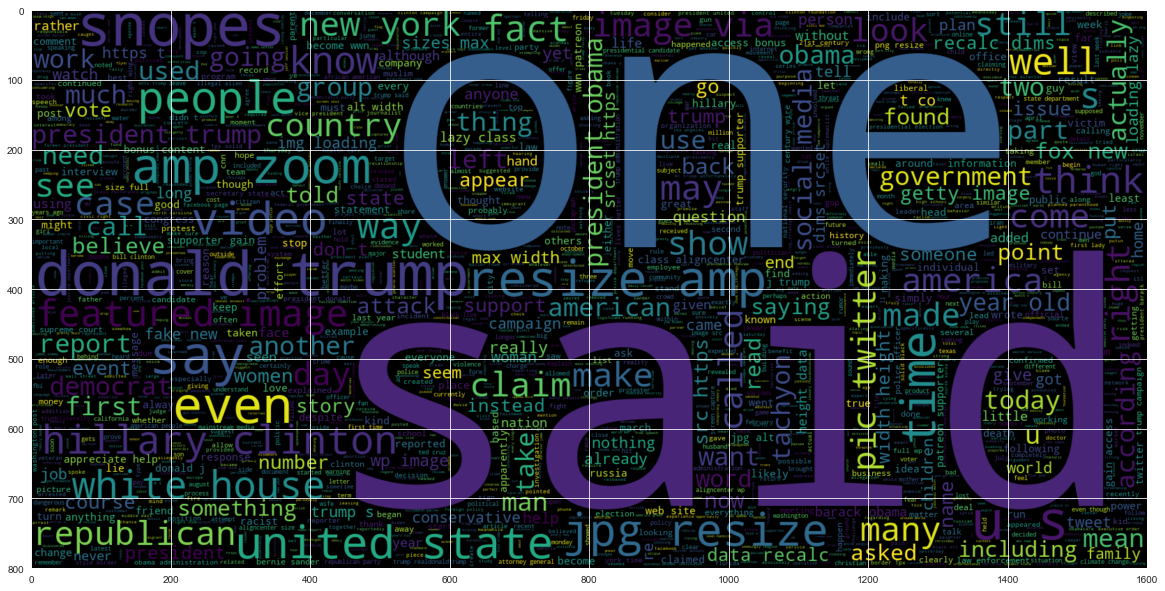

In [5]:
# wordcloud fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text_0))
plt.imshow(wc , interpolation = 'bilinear')

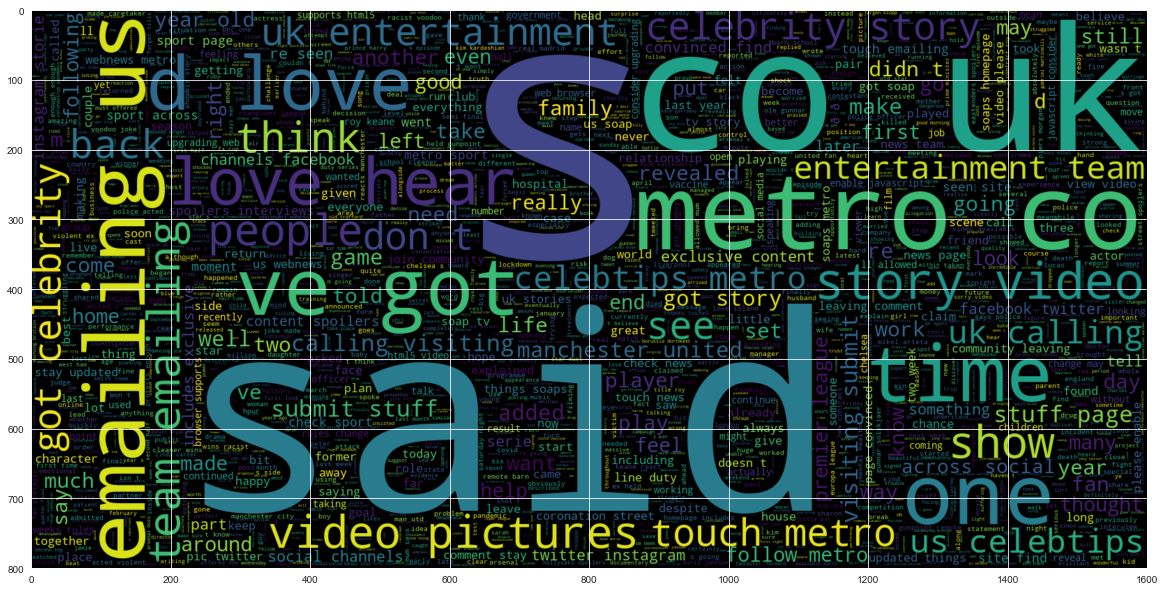

In [13]:
# wordcloud not fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text_0))
plt.imshow(wc , interpolation = 'bilinear')

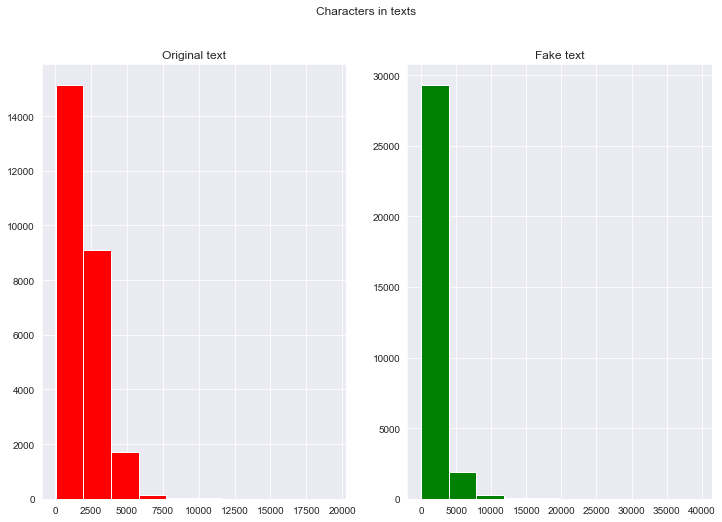

In [6]:
# Number of characters in texts

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['label']==1]['text_0'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

text_len=df[df['label']==0]['text_0'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')

plt.show()

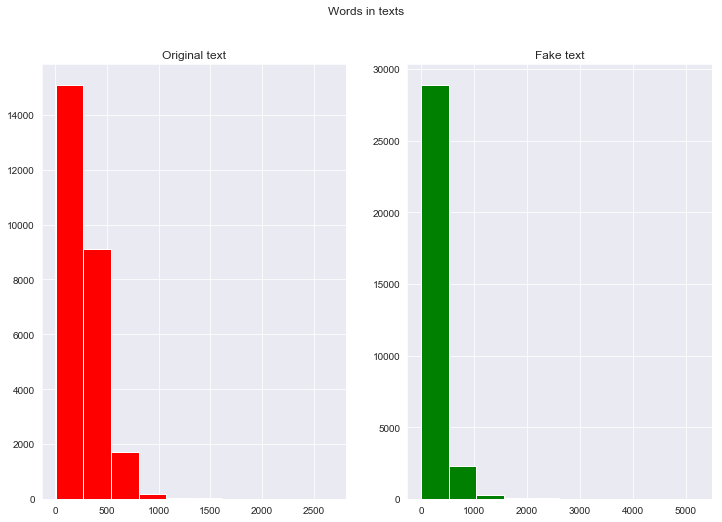

In [7]:
# Number of words in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['label']==1]['text_0'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

text_len=df[df['label']==0]['text_0'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Words in texts')

plt.show()

C:\Users\juanjose.ariza\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Average word length in each text')

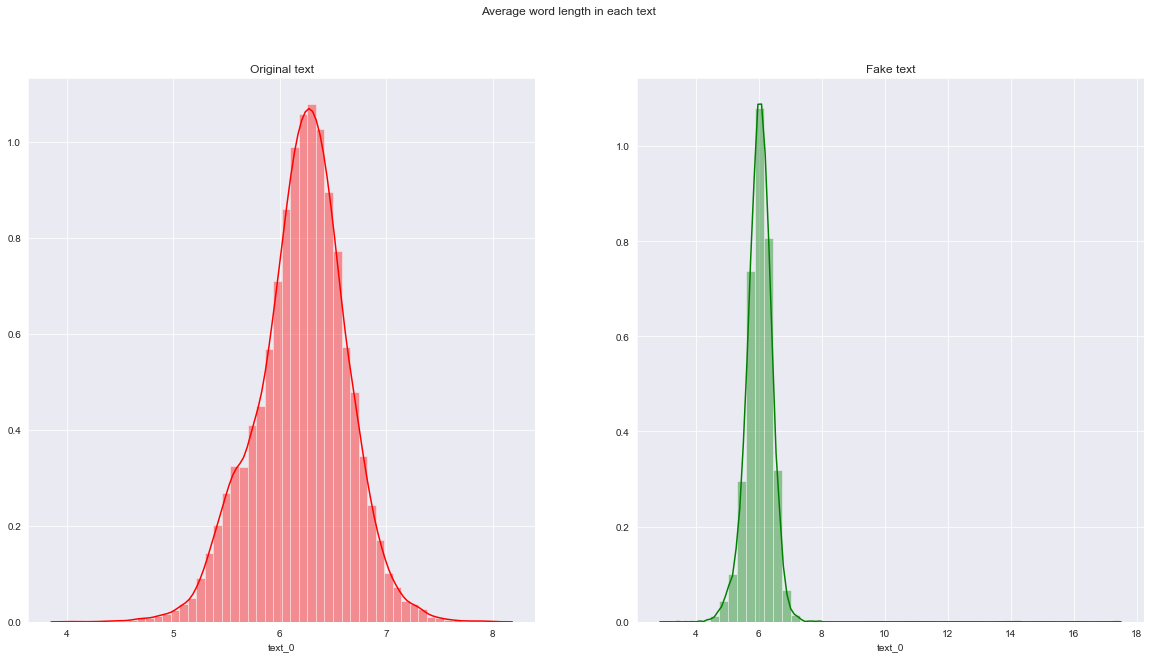

In [8]:
#Average word length in a text

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

word=df[df['label']==1]['text_0'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')

word=df[df['label']==0]['text_0'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')

In [8]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text_0)
corpus[:5]

['avon', 'reps', 'relocate', 'domestic', 'violence']

In [9]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'said': 147247,
 'trump': 145024,
 's': 70287,
 'would': 67240,
 'u': 64988,
 'president': 64306,
 'one': 56705,
 'people': 54803,
 'new': 41800,
 'also': 41074}

In [18]:
# Data cleaning
#merge fields
df["text_0"]=df["title"]+df["text"]

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = str(text)
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text_0']=df['text_0'].apply(denoise_text)


/Users/pilarpineiro/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/pilarpineiro/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpghttps://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/pilarpineiro/opt/anaconda3/

In [16]:

X,y=processed_df.text_0,processed_df.label

#Split data
x_train,x_test,y_train,y_test = train_test_split(df['text_0'],df.label,random_state = 0)

In [17]:
max_features = 10000
maxlen = 300

In [18]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [19]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [20]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [21]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [22]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/jota/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [23]:
batch_size = 256
epochs = 10
embed_size = 100

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [25]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [27]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
  1/171 [..............................] - ETA: 37:04 - loss: 0.6992 - accuracy: 0.4805

KeyboardInterrupt: 

In [45]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1356/1356 [==============================] - 116s 86ms/step - loss: 0.0477 - accuracy: 0.9788
Accuracy of the model on Training Data is -  97.87852168083191 %
452/452 [==============================] - 38s 85ms/step - loss: 0.0666 - accuracy: 0.9740
Accuracy of the model on Testing Data is -  97.39900231361389 %


In [55]:
model.save('nlp-glove.h5')

# new_model = tensorflow.keras.models.load_model('path_to_my_model.h5')

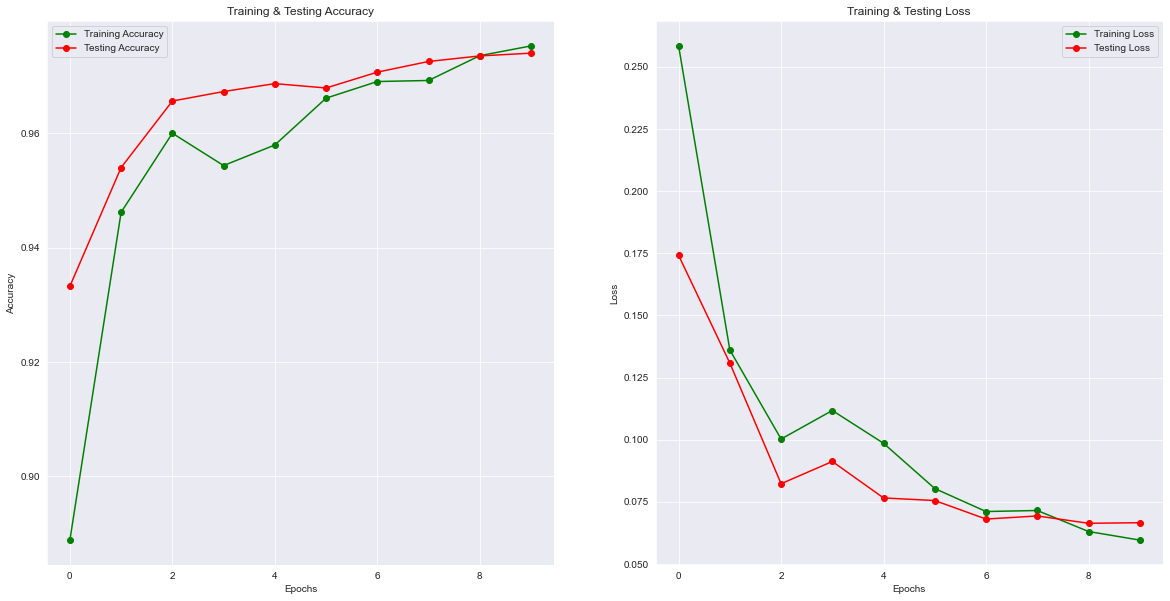

In [46]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [58]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

In [59]:
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.96      0.99      0.98      7964
    Not Fake       0.99      0.95      0.97      6492

    accuracy                           0.97     14456
   macro avg       0.98      0.97      0.97     14456
weighted avg       0.97      0.97      0.97     14456



In [60]:
cm = confusion_matrix(y_test,pred)
cm

array([[7913,   51],
       [ 325, 6167]])

In [61]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(70.0, 0.5, 'Actual')

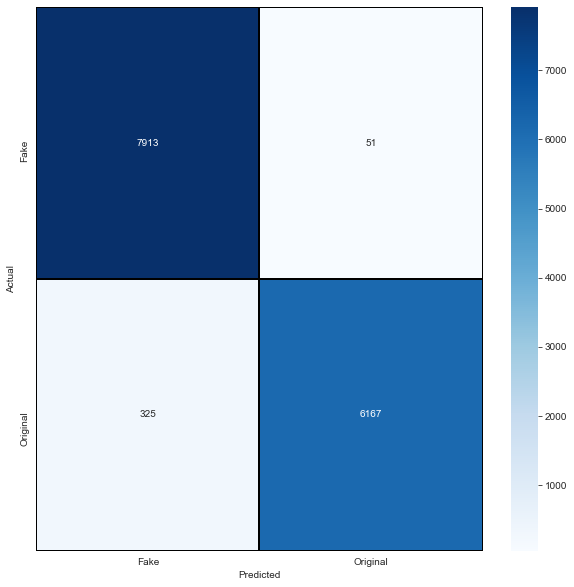

In [62]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [63]:
# testing other data

#merge fields
test_df["text_0"]=test_df["title"]+test_df["text"]

#Apply function on review column
test_df['text_0']=test_df['text_0'].apply(denoise_text)

In [65]:
pred = (model.predict(test_df) > 0.5).astype("int32")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type bool).

In [ ]:
cm = confusion_matrix(y_test,pred)
cm